# Exoplanet status prediction using Gradient Boosting Classifier

Data column meanings:
https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html#proj_disp_col
* koi_disposition:
    * CANDIDATE: A planetary candidate has passed all prior tests conducted to identify false positives, although this does not a priori mean that all possible tests have been conducted. A future test may confirm this KOI as a false positive.
    
    * FALSE POSITIVE: A false positive has failed at least one of the tests described in Batalha et al. (2012).
    
    * CONFIRMED: Cleary an exoplanet
    
A planetary candidate has passed all prior tests conducted to identify false positives, although this does not a priori mean that all possible tests have been conducted. A future test may confirm this KOI as a false positive. False positives can occur when: 1) the KOI is in reality an eclipsing binary star, 2) the Kepler light curve is contaminated by a background eclipsing binary, 3) stellar variability is confused for coherent planetary transits, or 4) instrumental artifacts are confused for coherent planetary transits.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

As a first step I load the data and separate it into two DataFrames.

One DataFrame will have the yet to be classified space objects, and the other one will have the objects already classified as an exoplanet or not.

In [2]:
exoplanet_data = pd.read_csv("exoplanet_data.csv")

# Drop the null rows
exoplanet_data = exoplanet_data.dropna()

#Create new DataFrame for candidate expoplanets
#candidate_exoplanets = exoplanet_data[exoplanet_data['koi_disposition'] == 'CANDIDATE']

# Filter out the planets labeled as candidates
#exoplanet_data = exoplanet_data[exoplanet_data['koi_disposition'] != 'CANDIDATE']


In [3]:
exoplanet_data.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


In [4]:
# Select from the second column to the last as X
X = exoplanet_data.iloc[:, 1:]
feature_names = X.columns

# Select koi_disposition as y
y= exoplanet_data['koi_disposition']

Now I scale the X dataframe so its values range from 0 to 1 and then split it in training and testing sets

In [5]:
# Define scaler object
scaler = MinMaxScaler().fit(X)

# Scale X
X_scaled = scaler.transform(X)

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify = y, random_state = 42)

## Gradient Boosting Classifier training and testing

Gradient Boosting Classifiers are a series of trees that are strongly pre-pruned before the training.

Each new tree tries to correct the mistakes of the previous one with the learning_rate parameter. How many trees are created is controlled with the n_estimators parameter.

In [6]:
param_grid = {'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5, 1],
              'n_estimators': [50, 75, 100, 125, 150, 175, 200],
              'max_depth': [4,5,6,7,8,9,10]}
grid = GridSearchCV(GradientBoostingClassifier(), param_grid, verbose=3)

# Fit the model using the grid search estimator. 
# This will take the SVC model and try each combination of parameters
grid.fit(X_train, y_train)

C:\Users\luisc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 294 candidates, totalling 882 fits
[CV] learning_rate=0.001, max_depth=4, n_estimators=50 ...............
[CV]  learning_rate=0.001, max_depth=4, n_estimators=50, score=0.5011441647597255, total=   1.7s
[CV] learning_rate=0.001, max_depth=4, n_estimators=50 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  learning_rate=0.001, max_depth=4, n_estimators=50, score=0.5011441647597255, total=   1.6s
[CV] learning_rate=0.001, max_depth=4, n_estimators=50 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV]  learning_rate=0.001, max_depth=4, n_estimators=50, score=0.5014310246136233, total=   1.6s
[CV] learning_rate=0.001, max_depth=4, n_estimators=75 ...............
[CV]  learning_rate=0.001, max_depth=4, n_estimators=75, score=0.5011441647597255, total=   2.3s
[CV] learning_rate=0.001, max_depth=4, n_estimators=75 ...............
[CV]  learning_rate=0.001, max_depth=4, n_estimators=75, score=0.5011441647597255, total=   2.3s
[CV] learning_rate=0.001, max_depth=4, n_estimators=75 ...............
[CV]  learning_rate=0.001, max_depth=4, n_estimators=75, score=0.5014310246136233, total=   2.3s
[CV] learning_rate=0.001, max_depth=4, n_estimators=100 ..............
[CV]  learning_rate=0.001, max_depth=4, n_estimators=100, score=0.6167048054919908, total=   3.6s
[CV] learning_rate=0.001, max_depth=4, n_estimators=100 ..............
[CV]  learning_rate=0.001, max_depth=4, n_estimators=100, score=0.5011441647597255, total=   3.2s
[CV] learning_rate=0.001, max_depth=4, n_estimators=100 .....

[CV]  learning_rate=0.001, max_depth=6, n_estimators=125, score=0.8255148741418764, total=   7.0s
[CV] learning_rate=0.001, max_depth=6, n_estimators=125 ..............
[CV]  learning_rate=0.001, max_depth=6, n_estimators=125, score=0.8209382151029748, total=   8.0s
[CV] learning_rate=0.001, max_depth=6, n_estimators=125 ..............
[CV]  learning_rate=0.001, max_depth=6, n_estimators=125, score=0.8328563251287923, total=   7.0s
[CV] learning_rate=0.001, max_depth=6, n_estimators=150 ..............
[CV]  learning_rate=0.001, max_depth=6, n_estimators=150, score=0.8381006864988558, total=  10.1s
[CV] learning_rate=0.001, max_depth=6, n_estimators=150 ..............
[CV]  learning_rate=0.001, max_depth=6, n_estimators=150, score=0.8575514874141876, total=   8.6s
[CV] learning_rate=0.001, max_depth=6, n_estimators=150 ..............
[CV]  learning_rate=0.001, max_depth=6, n_estimators=150, score=0.8528906697195192, total=  10.3s
[CV] learning_rate=0.001, max_depth=6, n_estimators=175 .

[CV]  learning_rate=0.001, max_depth=8, n_estimators=175, score=0.8615560640732265, total=  14.9s
[CV] learning_rate=0.001, max_depth=8, n_estimators=175 ..............
[CV]  learning_rate=0.001, max_depth=8, n_estimators=175, score=0.859187178019462, total=  13.7s
[CV] learning_rate=0.001, max_depth=8, n_estimators=200 ..............
[CV]  learning_rate=0.001, max_depth=8, n_estimators=200, score=0.8752860411899314, total=  16.2s
[CV] learning_rate=0.001, max_depth=8, n_estimators=200 ..............
[CV]  learning_rate=0.001, max_depth=8, n_estimators=200, score=0.8741418764302059, total=  16.5s
[CV] learning_rate=0.001, max_depth=8, n_estimators=200 ..............
[CV]  learning_rate=0.001, max_depth=8, n_estimators=200, score=0.8649112764739554, total=  16.0s
[CV] learning_rate=0.001, max_depth=9, n_estimators=50 ...............
[CV]  learning_rate=0.001, max_depth=9, n_estimators=50, score=0.5011441647597255, total=   4.1s
[CV] learning_rate=0.001, max_depth=9, n_estimators=50 ....

[CV]  learning_rate=0.01, max_depth=4, n_estimators=50, score=0.8803663423010876, total=   2.1s
[CV] learning_rate=0.01, max_depth=4, n_estimators=75 ................
[CV]  learning_rate=0.01, max_depth=4, n_estimators=75, score=0.8844393592677345, total=   3.5s
[CV] learning_rate=0.01, max_depth=4, n_estimators=75 ................
[CV]  learning_rate=0.01, max_depth=4, n_estimators=75, score=0.8918764302059496, total=   2.8s
[CV] learning_rate=0.01, max_depth=4, n_estimators=75 ................
[CV]  learning_rate=0.01, max_depth=4, n_estimators=75, score=0.8855180309101317, total=   2.7s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, score=0.8832951945080092, total=   3.6s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, score=0.8918764302059496, total=   3.9s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100 ............

[CV]  learning_rate=0.01, max_depth=6, n_estimators=125, score=0.8924485125858124, total=   8.1s
[CV] learning_rate=0.01, max_depth=6, n_estimators=125 ...............
[CV]  learning_rate=0.01, max_depth=6, n_estimators=125, score=0.8993135011441648, total=   8.7s
[CV] learning_rate=0.01, max_depth=6, n_estimators=125 ...............
[CV]  learning_rate=0.01, max_depth=6, n_estimators=125, score=0.8900973096737264, total=   8.5s
[CV] learning_rate=0.01, max_depth=6, n_estimators=150 ...............
[CV]  learning_rate=0.01, max_depth=6, n_estimators=150, score=0.8953089244851259, total=  10.7s
[CV] learning_rate=0.01, max_depth=6, n_estimators=150 ...............
[CV]  learning_rate=0.01, max_depth=6, n_estimators=150, score=0.9016018306636155, total=  10.8s
[CV] learning_rate=0.01, max_depth=6, n_estimators=150 ...............
[CV]  learning_rate=0.01, max_depth=6, n_estimators=150, score=0.8906697195191757, total=  10.3s
[CV] learning_rate=0.01, max_depth=6, n_estimators=175 ........

[CV]  learning_rate=0.01, max_depth=8, n_estimators=175, score=0.8993135011441648, total=  15.8s
[CV] learning_rate=0.01, max_depth=8, n_estimators=175 ...............
[CV]  learning_rate=0.01, max_depth=8, n_estimators=175, score=0.8900973096737264, total=  16.6s
[CV] learning_rate=0.01, max_depth=8, n_estimators=200 ...............
[CV]  learning_rate=0.01, max_depth=8, n_estimators=200, score=0.9004576659038902, total=  17.9s
[CV] learning_rate=0.01, max_depth=8, n_estimators=200 ...............
[CV]  learning_rate=0.01, max_depth=8, n_estimators=200, score=0.8998855835240275, total=  18.3s
[CV] learning_rate=0.01, max_depth=8, n_estimators=200 ...............
[CV]  learning_rate=0.01, max_depth=8, n_estimators=200, score=0.8883800801373783, total=  17.8s
[CV] learning_rate=0.01, max_depth=9, n_estimators=50 ................
[CV]  learning_rate=0.01, max_depth=9, n_estimators=50, score=0.8913043478260869, total=   4.8s
[CV] learning_rate=0.01, max_depth=9, n_estimators=50 ..........

[CV]  learning_rate=0.05, max_depth=4, n_estimators=50, score=0.8895248998282771, total=   1.4s
[CV] learning_rate=0.05, max_depth=4, n_estimators=75 ................
[CV]  learning_rate=0.05, max_depth=4, n_estimators=75, score=0.9010297482837528, total=   2.1s
[CV] learning_rate=0.05, max_depth=4, n_estimators=75 ................
[CV]  learning_rate=0.05, max_depth=4, n_estimators=75, score=0.8993135011441648, total=   2.1s
[CV] learning_rate=0.05, max_depth=4, n_estimators=75 ................
[CV]  learning_rate=0.05, max_depth=4, n_estimators=75, score=0.8929593589009731, total=   2.2s
[CV] learning_rate=0.05, max_depth=4, n_estimators=100 ...............
[CV]  learning_rate=0.05, max_depth=4, n_estimators=100, score=0.9004576659038902, total=   2.9s
[CV] learning_rate=0.05, max_depth=4, n_estimators=100 ...............
[CV]  learning_rate=0.05, max_depth=4, n_estimators=100, score=0.9010297482837528, total=   2.8s
[CV] learning_rate=0.05, max_depth=4, n_estimators=100 ............

[CV]  learning_rate=0.05, max_depth=6, n_estimators=125, score=0.9073226544622426, total=   6.5s
[CV] learning_rate=0.05, max_depth=6, n_estimators=125 ...............
[CV]  learning_rate=0.05, max_depth=6, n_estimators=125, score=0.9021739130434783, total=   6.4s
[CV] learning_rate=0.05, max_depth=6, n_estimators=125 ...............
[CV]  learning_rate=0.05, max_depth=6, n_estimators=125, score=0.8963938179736691, total=   6.7s
[CV] learning_rate=0.05, max_depth=6, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=6, n_estimators=150, score=0.9056064073226545, total=   7.6s
[CV] learning_rate=0.05, max_depth=6, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=6, n_estimators=150, score=0.9010297482837528, total=   7.9s
[CV] learning_rate=0.05, max_depth=6, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=6, n_estimators=150, score=0.8958214081282198, total=   7.6s
[CV] learning_rate=0.05, max_depth=6, n_estimators=175 ........

[CV]  learning_rate=0.05, max_depth=8, n_estimators=175, score=0.8964530892448512, total=  17.7s
[CV] learning_rate=0.05, max_depth=8, n_estimators=175 ...............
[CV]  learning_rate=0.05, max_depth=8, n_estimators=175, score=0.887807670291929, total=  17.7s
[CV] learning_rate=0.05, max_depth=8, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=8, n_estimators=200, score=0.9004576659038902, total=  19.7s
[CV] learning_rate=0.05, max_depth=8, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=8, n_estimators=200, score=0.8958810068649885, total=  20.3s
[CV] learning_rate=0.05, max_depth=8, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=8, n_estimators=200, score=0.8912421293646251, total=  20.1s
[CV] learning_rate=0.05, max_depth=9, n_estimators=50 ................
[CV]  learning_rate=0.05, max_depth=9, n_estimators=50, score=0.897025171624714, total=   6.2s
[CV] learning_rate=0.05, max_depth=9, n_estimators=50 ............

[CV]  learning_rate=0.1, max_depth=4, n_estimators=50, score=0.8981110475100171, total=   1.7s
[CV] learning_rate=0.1, max_depth=4, n_estimators=75 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=75, score=0.9004576659038902, total=   2.5s
[CV] learning_rate=0.1, max_depth=4, n_estimators=75 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=75, score=0.9044622425629291, total=   2.7s
[CV] learning_rate=0.1, max_depth=4, n_estimators=75 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=75, score=0.8975386376645679, total=   2.7s
[CV] learning_rate=0.1, max_depth=4, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=100, score=0.8975972540045767, total=   3.3s
[CV] learning_rate=0.1, max_depth=4, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=100, score=0.9050343249427918, total=   3.2s
[CV] learning_rate=0.1, max_depth=4, n_estimators=100 ................
[C

[CV]  learning_rate=0.1, max_depth=6, n_estimators=125, score=0.8981693363844394, total=   7.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=125 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=125, score=0.8935317687464225, total=   8.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=150 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=150, score=0.8993135011441648, total=   9.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=150 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=150, score=0.8993135011441648, total=  10.7s
[CV] learning_rate=0.1, max_depth=6, n_estimators=150 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=150, score=0.8929593589009731, total=   9.7s
[CV] learning_rate=0.1, max_depth=6, n_estimators=175 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=175, score=0.902745995423341, total=  11.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=175 ................

[CV]  learning_rate=0.1, max_depth=8, n_estimators=200, score=0.9010297482837528, total=  17.9s
[CV] learning_rate=0.1, max_depth=8, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=200, score=0.8947368421052632, total=  17.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=200, score=0.8946765884373211, total=  17.6s
[CV] learning_rate=0.1, max_depth=9, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=9, n_estimators=50, score=0.8964530892448512, total=   6.5s
[CV] learning_rate=0.1, max_depth=9, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=9, n_estimators=50, score=0.8998855835240275, total=   6.9s
[CV] learning_rate=0.1, max_depth=9, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=9, n_estimators=50, score=0.8900973096737264, total=   6.8s
[CV] learning_rate=0.1, max_depth=9, n_estimators=75 .................
[

[CV]  learning_rate=0.5, max_depth=4, n_estimators=75, score=0.8969662278191185, total=   2.4s
[CV] learning_rate=0.5, max_depth=4, n_estimators=100 ................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=100, score=0.8918764302059496, total=   3.6s
[CV] learning_rate=0.5, max_depth=4, n_estimators=100 ................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=100, score=0.8953089244851259, total=   3.7s
[CV] learning_rate=0.5, max_depth=4, n_estimators=100 ................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=100, score=0.8958214081282198, total=   3.2s
[CV] learning_rate=0.5, max_depth=4, n_estimators=125 ................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=125, score=0.8907322654462243, total=   4.0s
[CV] learning_rate=0.5, max_depth=4, n_estimators=125 ................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=125, score=0.898741418764302, total=   4.2s
[CV] learning_rate=0.5, max_depth=4, n_estimators=125 ................


[CV]  learning_rate=0.5, max_depth=6, n_estimators=150, score=0.9021739130434783, total=   4.8s
[CV] learning_rate=0.5, max_depth=6, n_estimators=150 ................
[CV]  learning_rate=0.5, max_depth=6, n_estimators=150, score=0.8923869490555237, total=   4.4s
[CV] learning_rate=0.5, max_depth=6, n_estimators=175 ................
[CV]  learning_rate=0.5, max_depth=6, n_estimators=175, score=0.9010297482837528, total=   4.8s
[CV] learning_rate=0.5, max_depth=6, n_estimators=175 ................
[CV]  learning_rate=0.5, max_depth=6, n_estimators=175, score=0.9010297482837528, total=   5.1s
[CV] learning_rate=0.5, max_depth=6, n_estimators=175 ................
[CV]  learning_rate=0.5, max_depth=6, n_estimators=175, score=0.8889524899828277, total=   4.4s
[CV] learning_rate=0.5, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.5, max_depth=6, n_estimators=200, score=0.9016018306636155, total=   4.8s
[CV] learning_rate=0.5, max_depth=6, n_estimators=200 ...............

[CV]  learning_rate=0.5, max_depth=9, n_estimators=50, score=0.898741418764302, total=   3.4s
[CV] learning_rate=0.5, max_depth=9, n_estimators=50 .................
[CV]  learning_rate=0.5, max_depth=9, n_estimators=50, score=0.902745995423341, total=   2.9s
[CV] learning_rate=0.5, max_depth=9, n_estimators=50 .................
[CV]  learning_rate=0.5, max_depth=9, n_estimators=50, score=0.887807670291929, total=   2.8s
[CV] learning_rate=0.5, max_depth=9, n_estimators=75 .................
[CV]  learning_rate=0.5, max_depth=9, n_estimators=75, score=0.8935926773455377, total=   2.9s
[CV] learning_rate=0.5, max_depth=9, n_estimators=75 .................
[CV]  learning_rate=0.5, max_depth=9, n_estimators=75, score=0.9038901601830663, total=   3.3s
[CV] learning_rate=0.5, max_depth=9, n_estimators=75 .................
[CV]  learning_rate=0.5, max_depth=9, n_estimators=75, score=0.8923869490555237, total=   3.0s
[CV] learning_rate=0.5, max_depth=9, n_estimators=100 ................
[CV]  l

[CV]  learning_rate=1, max_depth=4, n_estimators=100, score=0.8872352604464797, total=   2.5s
[CV] learning_rate=1, max_depth=4, n_estimators=125 ..................
[CV]  learning_rate=1, max_depth=4, n_estimators=125, score=0.8953089244851259, total=   2.7s
[CV] learning_rate=1, max_depth=4, n_estimators=125 ..................
[CV]  learning_rate=1, max_depth=4, n_estimators=125, score=0.8907322654462243, total=   2.8s
[CV] learning_rate=1, max_depth=4, n_estimators=125 ..................
[CV]  learning_rate=1, max_depth=4, n_estimators=125, score=0.8866628506010303, total=   2.6s
[CV] learning_rate=1, max_depth=4, n_estimators=150 ..................
[CV]  learning_rate=1, max_depth=4, n_estimators=150, score=0.8872997711670481, total=   2.7s
[CV] learning_rate=1, max_depth=4, n_estimators=150 ..................
[CV]  learning_rate=1, max_depth=4, n_estimators=150, score=0.8930205949656751, total=   3.1s
[CV] learning_rate=1, max_depth=4, n_estimators=150 ..................
[CV]  lear

[CV]  learning_rate=1, max_depth=6, n_estimators=175, score=0.8941647597254004, total=   2.2s
[CV] learning_rate=1, max_depth=6, n_estimators=175 ..................
[CV]  learning_rate=1, max_depth=6, n_estimators=175, score=0.8815111619919863, total=   2.3s
[CV] learning_rate=1, max_depth=6, n_estimators=200 ..................
[CV]  learning_rate=1, max_depth=6, n_estimators=200, score=0.8935926773455377, total=   3.1s
[CV] learning_rate=1, max_depth=6, n_estimators=200 ..................
[CV]  learning_rate=1, max_depth=6, n_estimators=200, score=0.8947368421052632, total=   2.6s
[CV] learning_rate=1, max_depth=6, n_estimators=200 ..................
[CV]  learning_rate=1, max_depth=6, n_estimators=200, score=0.8855180309101317, total=   2.3s
[CV] learning_rate=1, max_depth=7, n_estimators=50 ...................
[CV]  learning_rate=1, max_depth=7, n_estimators=50, score=0.8913043478260869, total=   1.8s
[CV] learning_rate=1, max_depth=7, n_estimators=50 ...................
[CV]  learn

[CV]  learning_rate=1, max_depth=9, n_estimators=75, score=0.9004576659038902, total=   1.5s
[CV] learning_rate=1, max_depth=9, n_estimators=75 ...................
[CV]  learning_rate=1, max_depth=9, n_estimators=75, score=0.8953089244851259, total=   1.6s
[CV] learning_rate=1, max_depth=9, n_estimators=75 ...................
[CV]  learning_rate=1, max_depth=9, n_estimators=75, score=0.8792215226101889, total=   1.5s
[CV] learning_rate=1, max_depth=9, n_estimators=100 ..................
[CV]  learning_rate=1, max_depth=9, n_estimators=100, score=0.8958810068649885, total=   1.7s
[CV] learning_rate=1, max_depth=9, n_estimators=100 ..................
[CV]  learning_rate=1, max_depth=9, n_estimators=100, score=0.8924485125858124, total=   1.7s
[CV] learning_rate=1, max_depth=9, n_estimators=100 ..................
[CV]  learning_rate=1, max_depth=9, n_estimators=100, score=0.8855180309101317, total=   1.6s
[CV] learning_rate=1, max_depth=9, n_estimators=125 ..................
[CV]  learnin

[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed: 113.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5, 1], 'n_estimators': [50, 75, 100, 125, 150, 175, 200], 'max_depth': [4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [7]:
print('The best parameters to use are: ', grid.best_params_)

The best parameters to use are:  {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 125}


In [8]:
# Create the GradientBoostingClassifier object and train it
#learning_rate = 0.05, n_estimators = 125, 

gbc = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 125, max_depth = 6, random_state = 42).fit(X_train, y_train)

#Make a prediction for the X_test
prediction = gbc.predict(X_test)

print('Training set score: {:.3f}'.format(gbc.score(X_train, y_train)))
print('Test set score: {:.3f}'.format(gbc.score(X_test, y_test)))

Training set score: 0.989
Test set score: 0.910


In [9]:
# Show the feature importances with its feature name
sorted(zip(gbc.feature_importances_, feature_names), reverse=True) 

[(0.22926179260886562, 'koi_fpflag_co'),
 (0.19545045595536145, 'koi_fpflag_nt'),
 (0.15069859635801372, 'koi_fpflag_ss'),
 (0.08468235677463487, 'koi_model_snr'),
 (0.0688837060888711, 'koi_steff_err1'),
 (0.03305093288443346, 'koi_fpflag_ec'),
 (0.031757020410977346, 'koi_prad'),
 (0.022742785209558726, 'koi_duration_err1'),
 (0.016817087748584144, 'koi_duration'),
 (0.015380103169373119, 'koi_duration_err2'),
 (0.015336013678980792, 'koi_impact'),
 (0.013598697900983262, 'koi_period'),
 (0.01076738978632558, 'koi_prad_err2'),
 (0.010128898450673303, 'ra'),
 (0.007786922545530026, 'koi_kepmag'),
 (0.007621726568738126, 'koi_time0bk'),
 (0.00737194622570606, 'koi_depth'),
 (0.005920728855064126, 'koi_tce_plnt_num'),
 (0.005888023469728091, 'dec'),
 (0.005629871213355953, 'koi_prad_err1'),
 (0.005360647966358493, 'koi_impact_err2'),
 (0.005186715336138058, 'koi_steff_err2'),
 (0.005098122969890742, 'koi_depth_err1'),
 (0.004186727675294336, 'koi_depth_err2'),
 (0.0037042384874531576, '

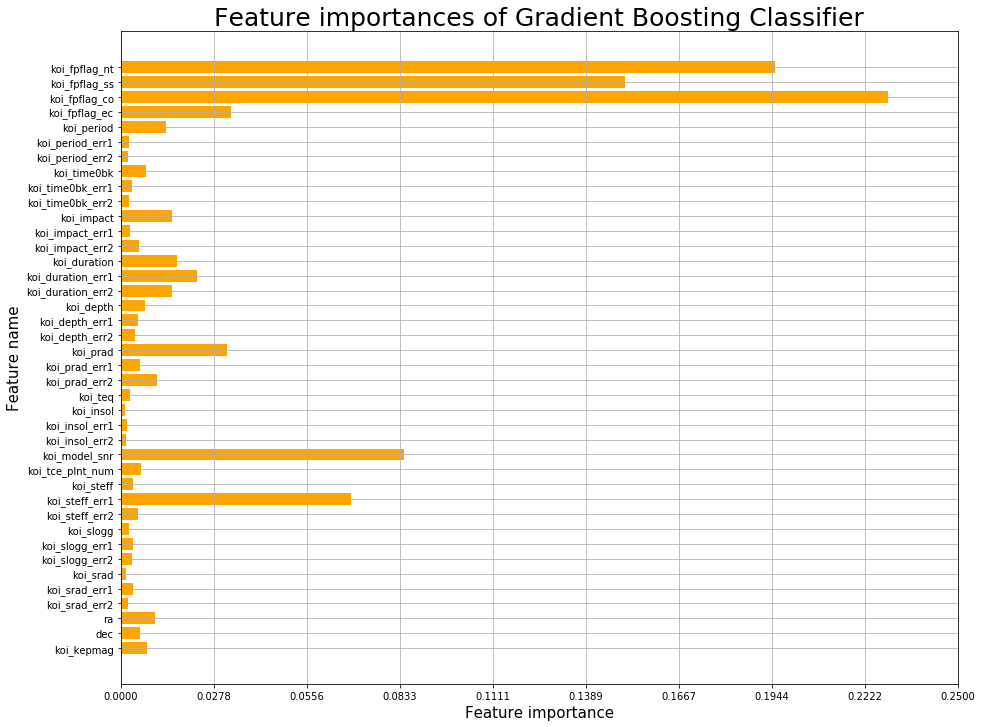

In [10]:
%matplotlib inline

fig, ax = plt.subplots(figsize = (15, 12))



y_pos = np.arange(len(feature_names))

ax.barh(y_pos, gbc.feature_importances_, align='center', color = 'orange')

ax.set_xticks(np.linspace(0, 0.25,10))
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature importance', size = 15)
ax.set_ylabel('Feature name', size = 15)
ax.grid()

ax.set_title('Feature importances of Gradient Boosting Classifier', size  = 25)


plt.show()